```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

## Image Crop Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twitter-research/image-crop-analysis/blob/master/notebooks/Image%20Crop%20Analysis.ipynb)

In [ ]:
import logging
import shlex
import subprocess
import sys
from collections import namedtuple
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

logging.basicConfig(level=logging.ERROR)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

In [ ]:
!cp -r /content/drive/MyDrive/Georgia_Tech/Summer_2021/CLAWS/Twitter_Challenge/images_new/* ./image-crop-analysis/data/

In [ ]:
!pwd

In [ ]:
img_path = next(data_dir.glob("./*.jpg"))
img_path

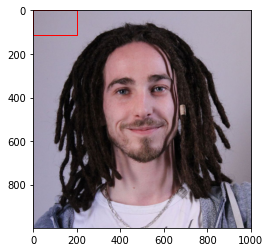

In [ ]:
img = mpimg.imread(img_path)
plt.imshow(img)
plt.gca().add_patch(
    Rectangle((0, 0), 200, 112, linewidth=1, edgecolor="r", facecolor="none")
)

In [ ]:
str(img_path.absolute())

In [ ]:
cmd = f"{str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points"
cmd

In [ ]:
output = subprocess.check_output(cmd, shell=True)  # Success!
print(output.splitlines())

In [ ]:
! {str(bin_path)} {str(model_path)} '{img_path.absolute()}' show_all_points | head

In [ ]:
from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling

In [ ]:
parse_output(output).keys()

In [ ]:
model = ImageSaliencyModel(crop_binary_path=bin_path, crop_model_path=model_path)

In [ ]:
plt.matplotlib.__version__

In [ ]:
list(data_dir.glob("./*.jpg"))

In [ ]:
for img_path in data_dir.glob("*.jpg"):
    print(img_path)
    model.plot_img_crops(img_path)

In [ ]:
for img_path in data_dir.glob("*.jpg"):
    print(img_path)
    model.plot_img_crops(img_path)

None 347 606
None 377 525
None 228 259
None 271 186
None 483 720


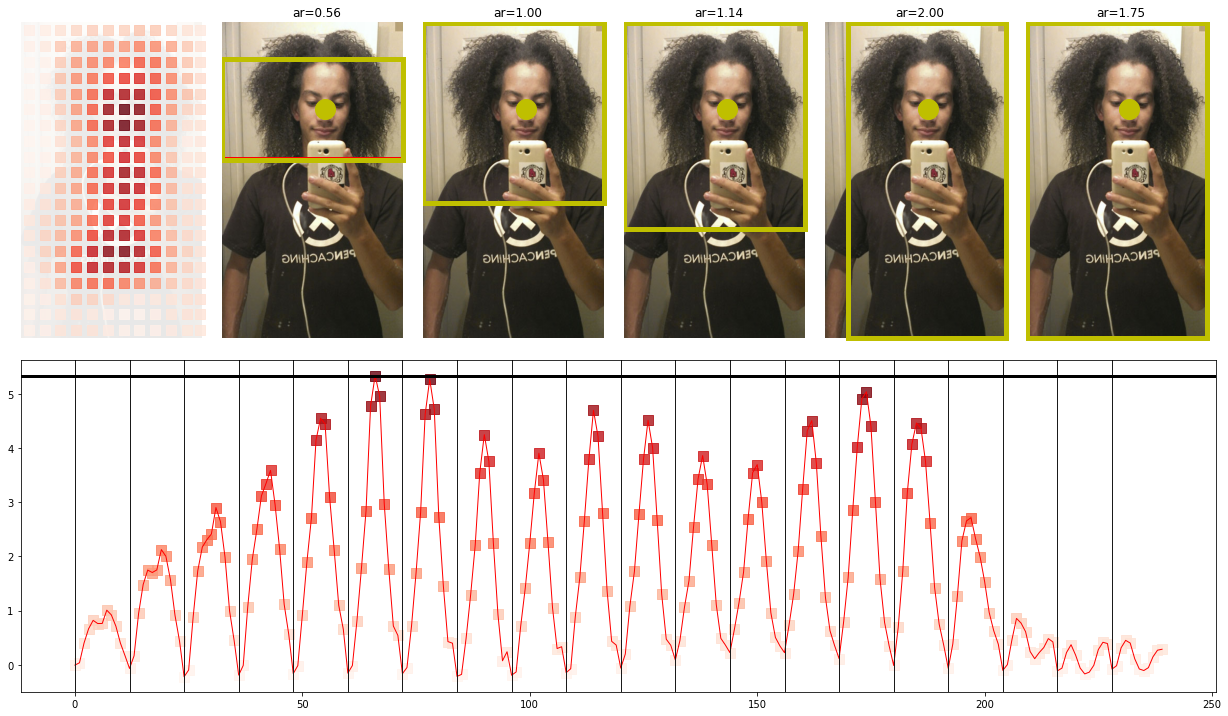

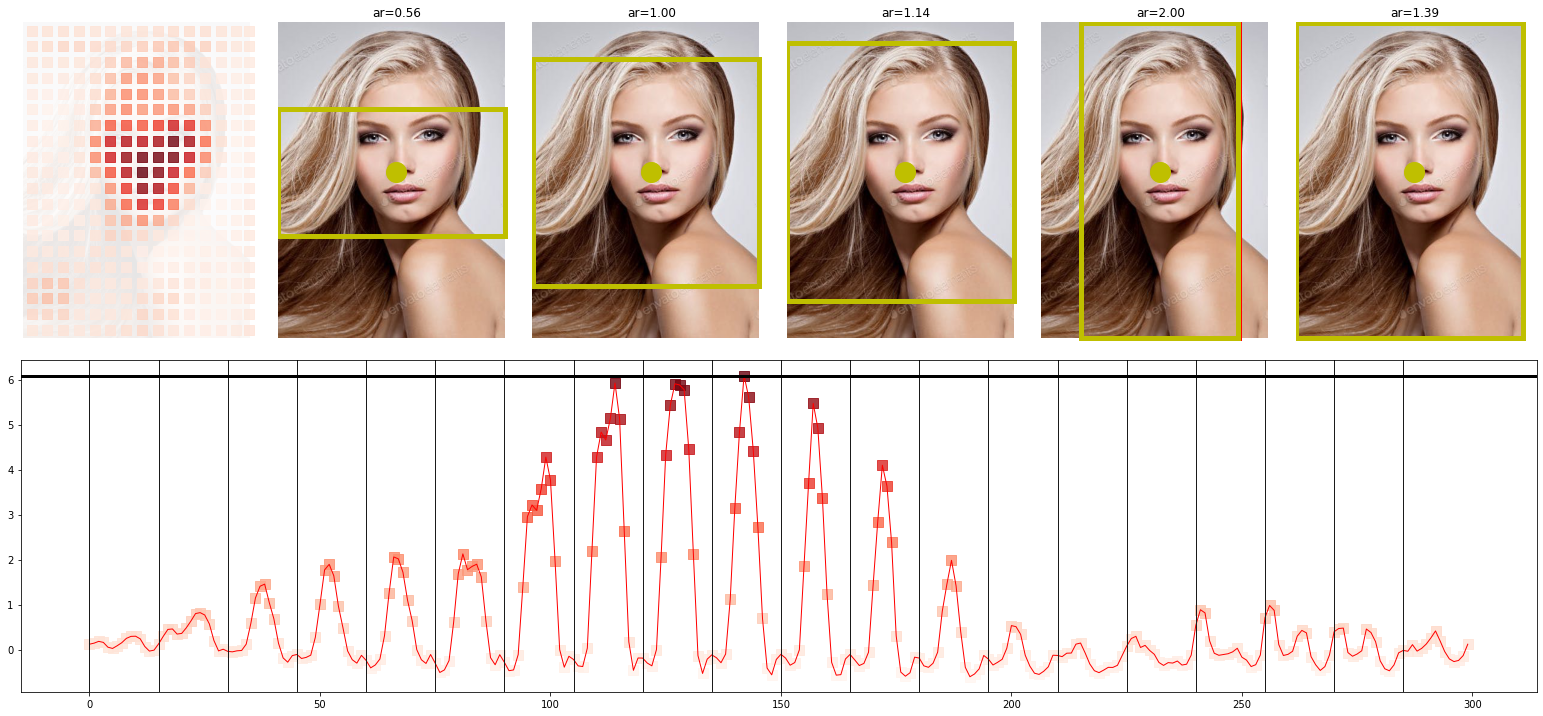

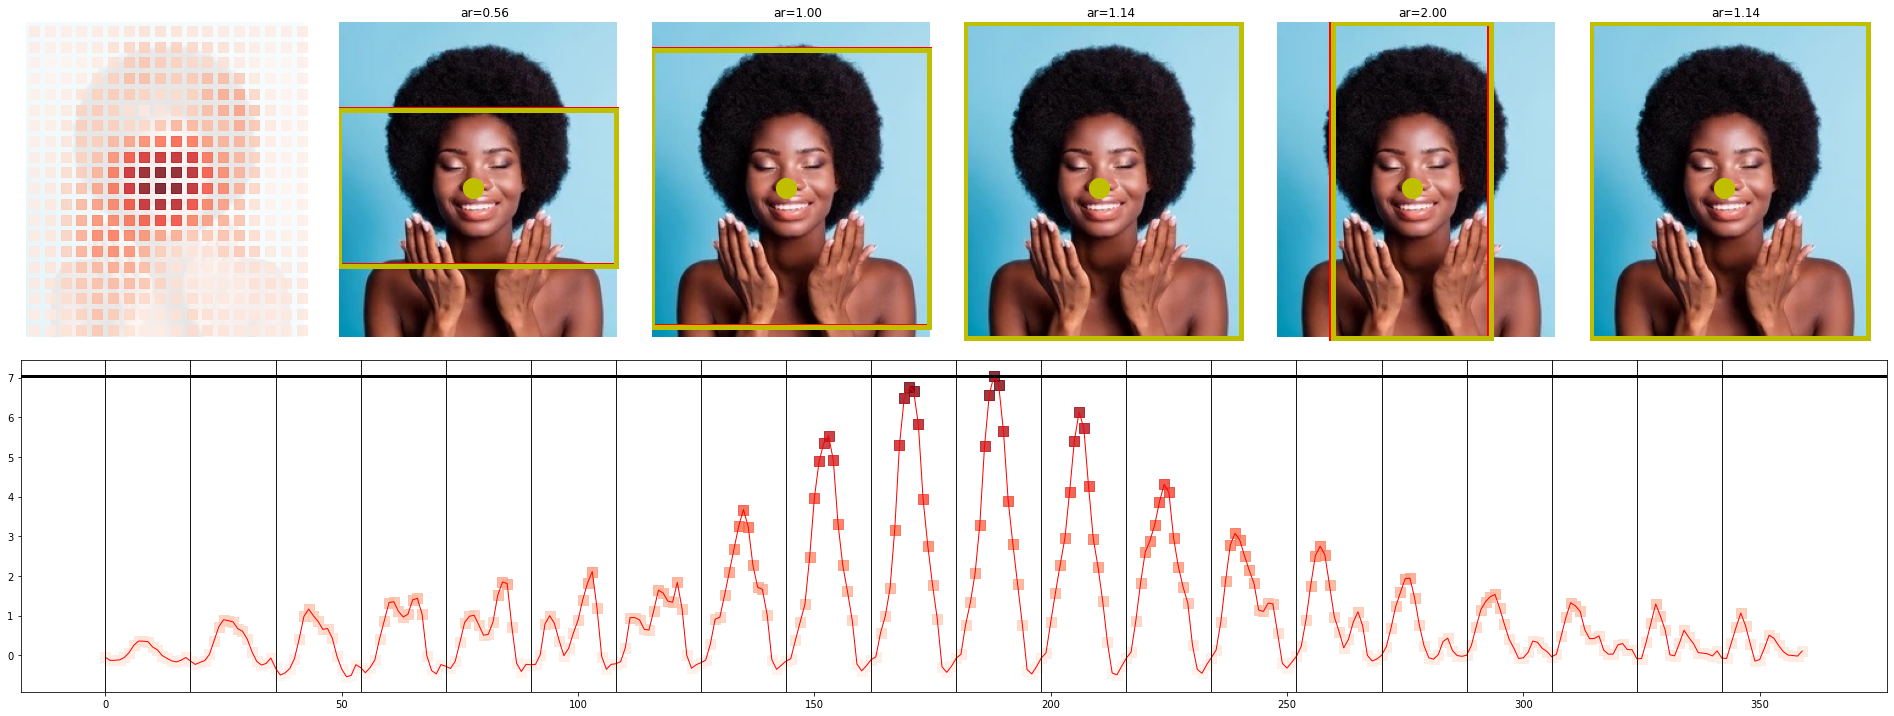

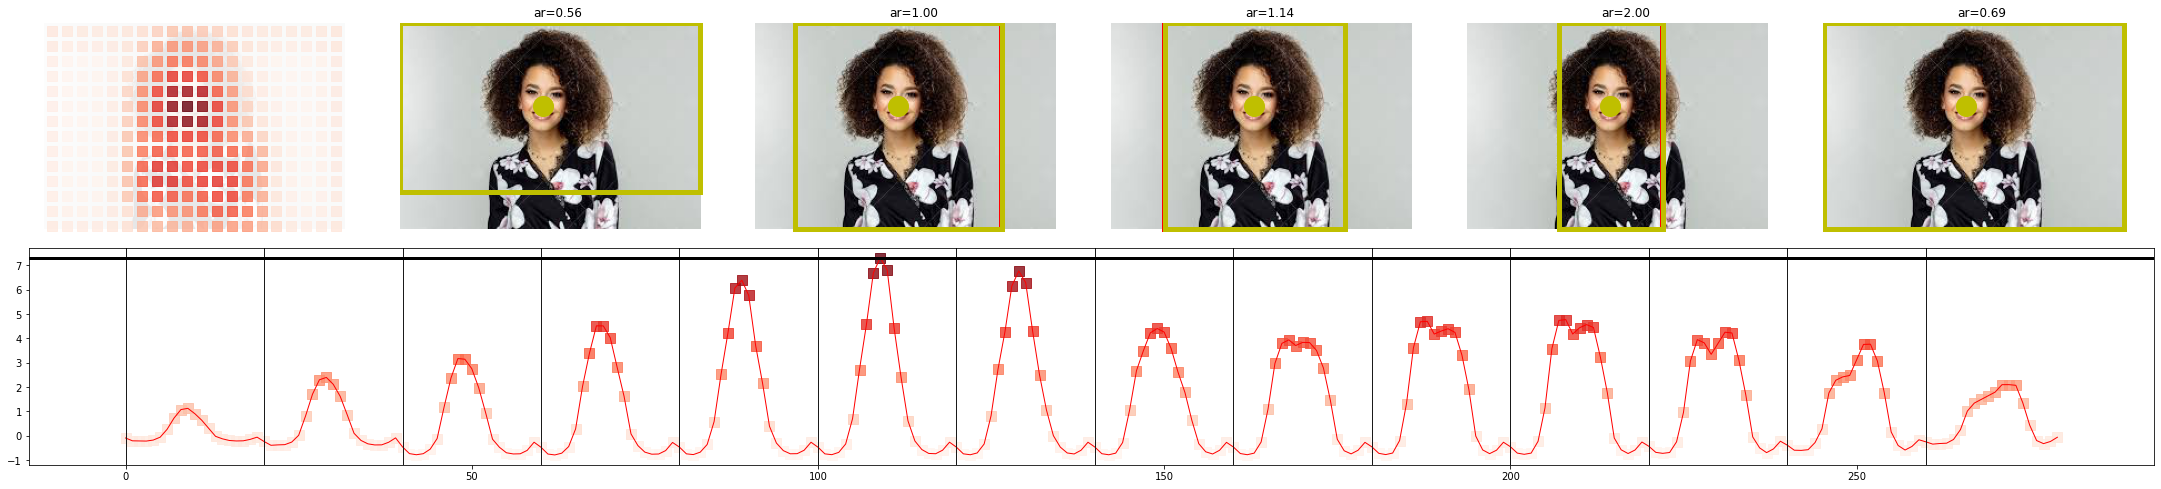

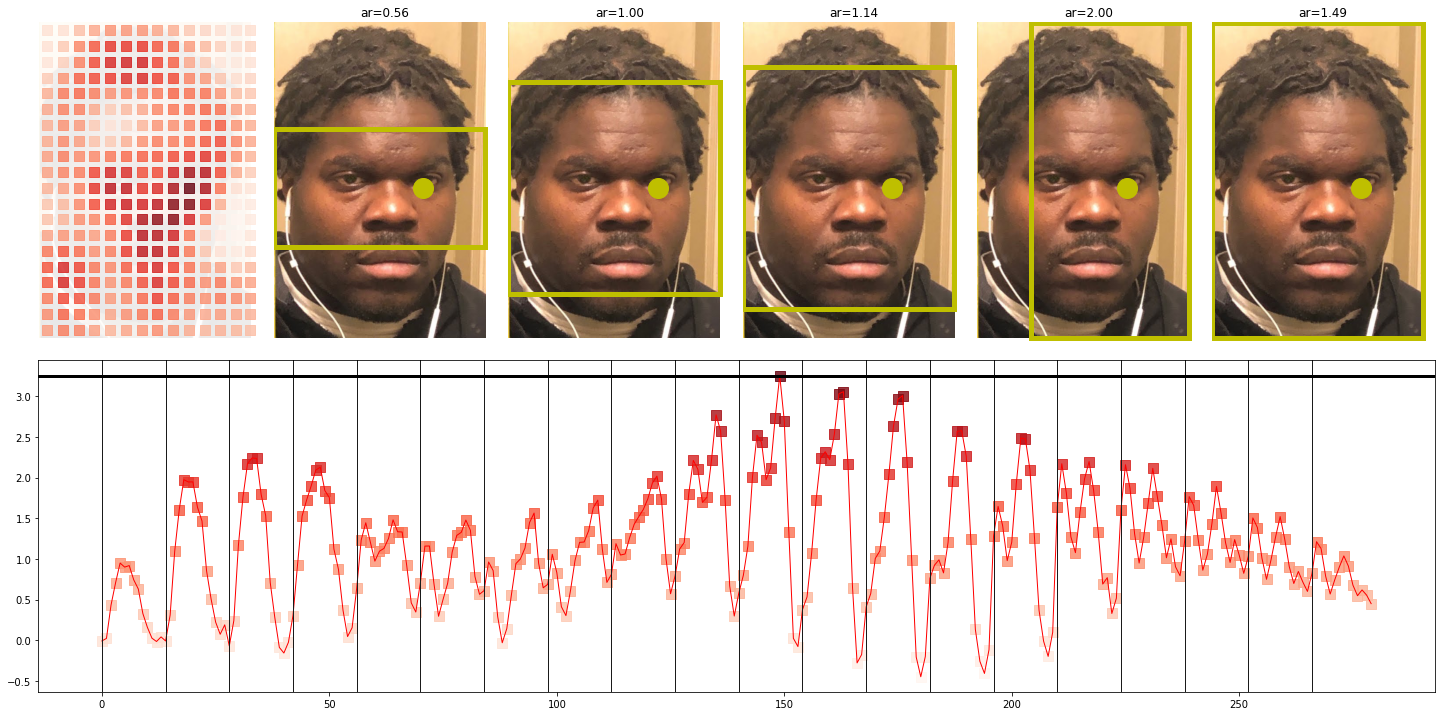

In [ ]:
for img_path in reservoir_sampling(data_dir.glob("./*.jpg"), K=5):
    model.plot_img_crops(img_path)

None 1034 851


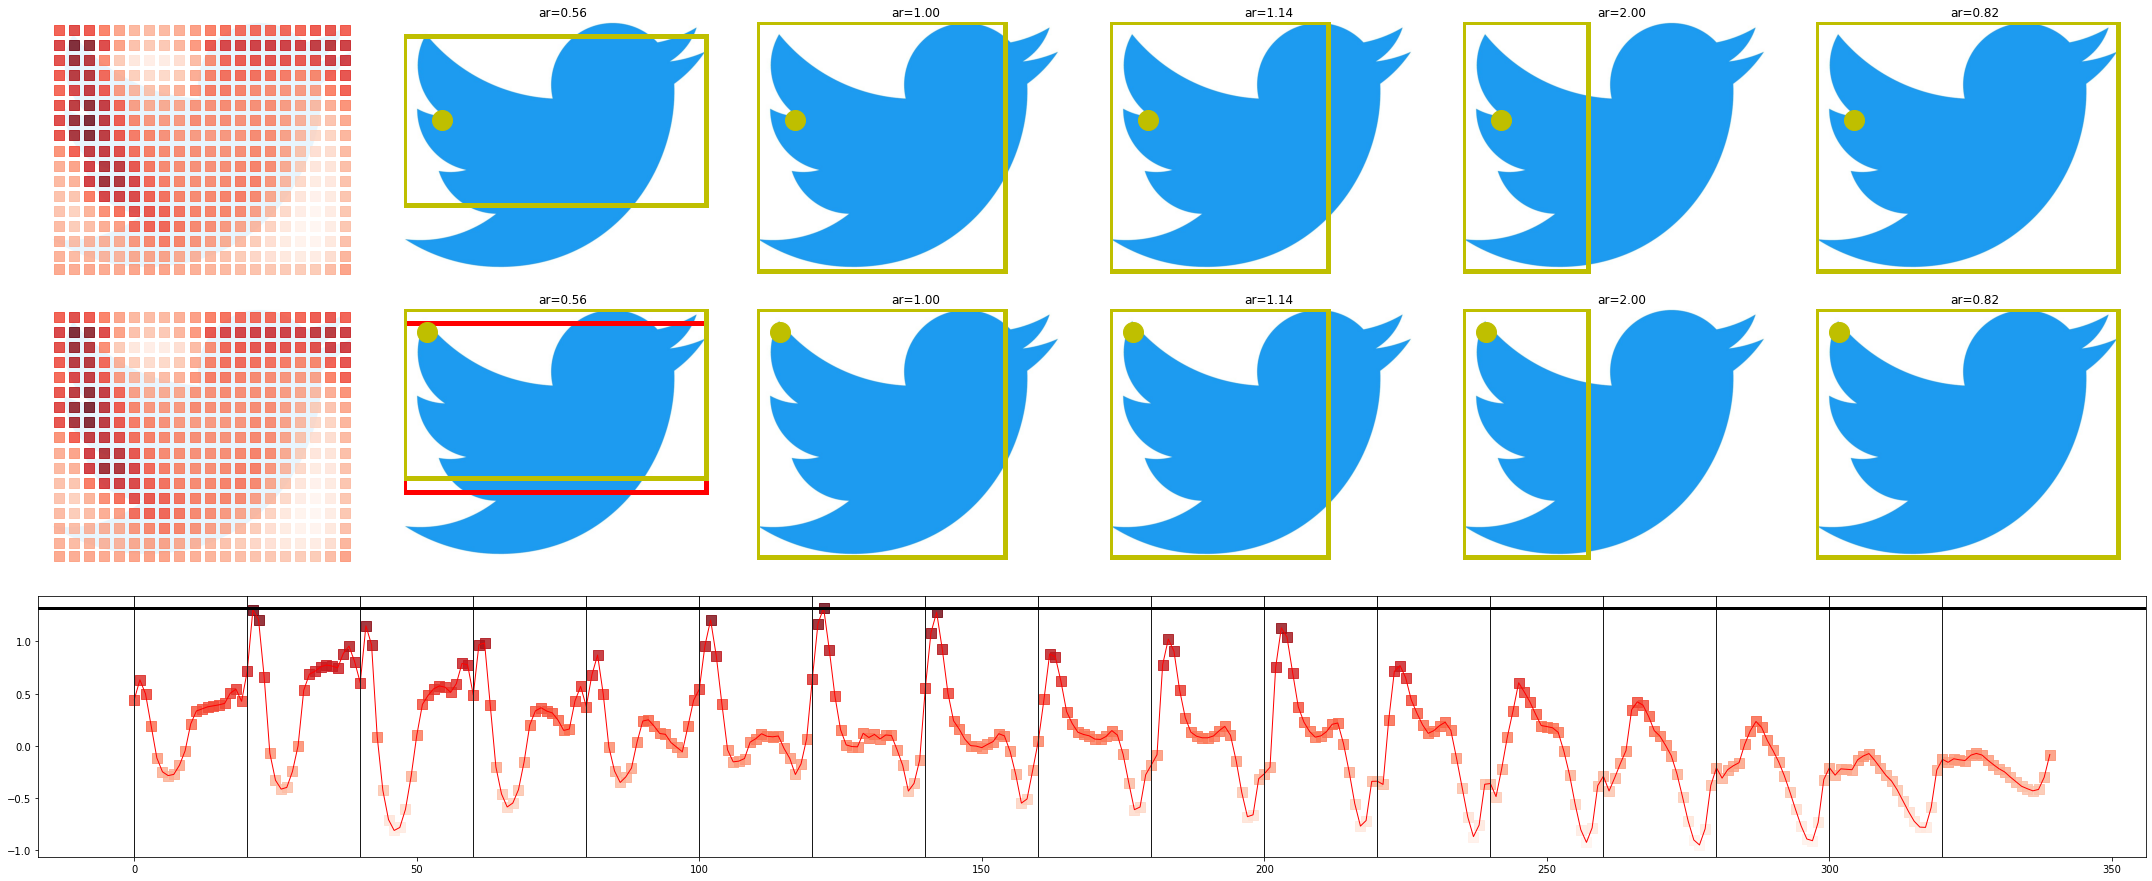

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=2)
plt.savefig("dummy.jpg", bbox_inches="tight")

## Sample crops based on saliency scores


* First, we show the top 3 crops based sorted saliency scores (highest first)
* Next, we show the top 3 crops sampled based on saliency scores converted into probs using the following formula:

$$
\begin{equation}
p_i = \frac{exp(s_i)}{Z}\\
Z = \sum_{j=0}^{j=N} exp(s_j)
\end{equation}
$$

None 1034 851


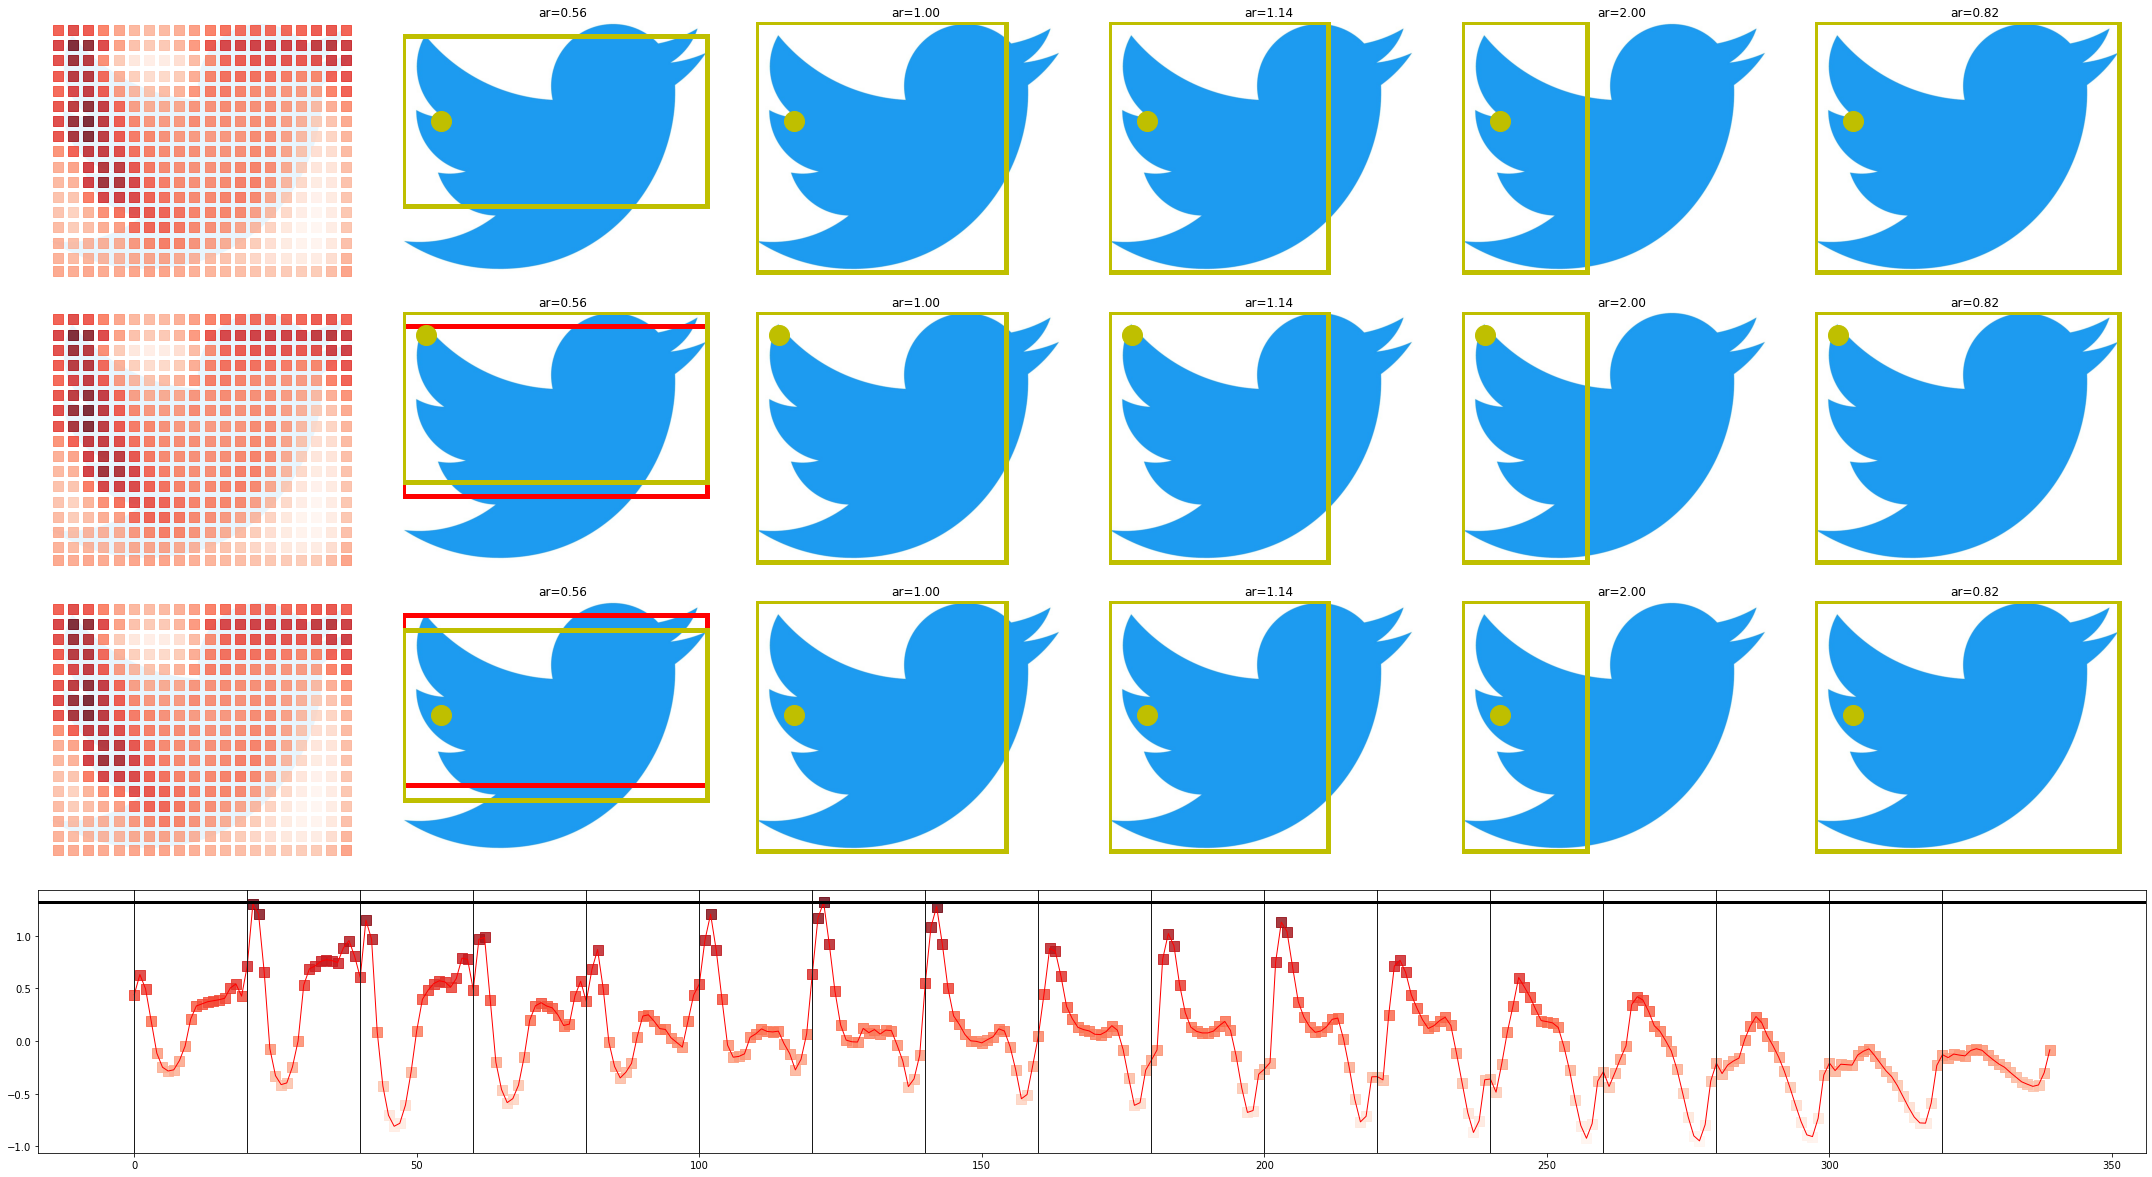

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=3)
plt.savefig("dummy_top3.jpeg", bbox_inches="tight")

None 1034 851


(284.35, 846.588)

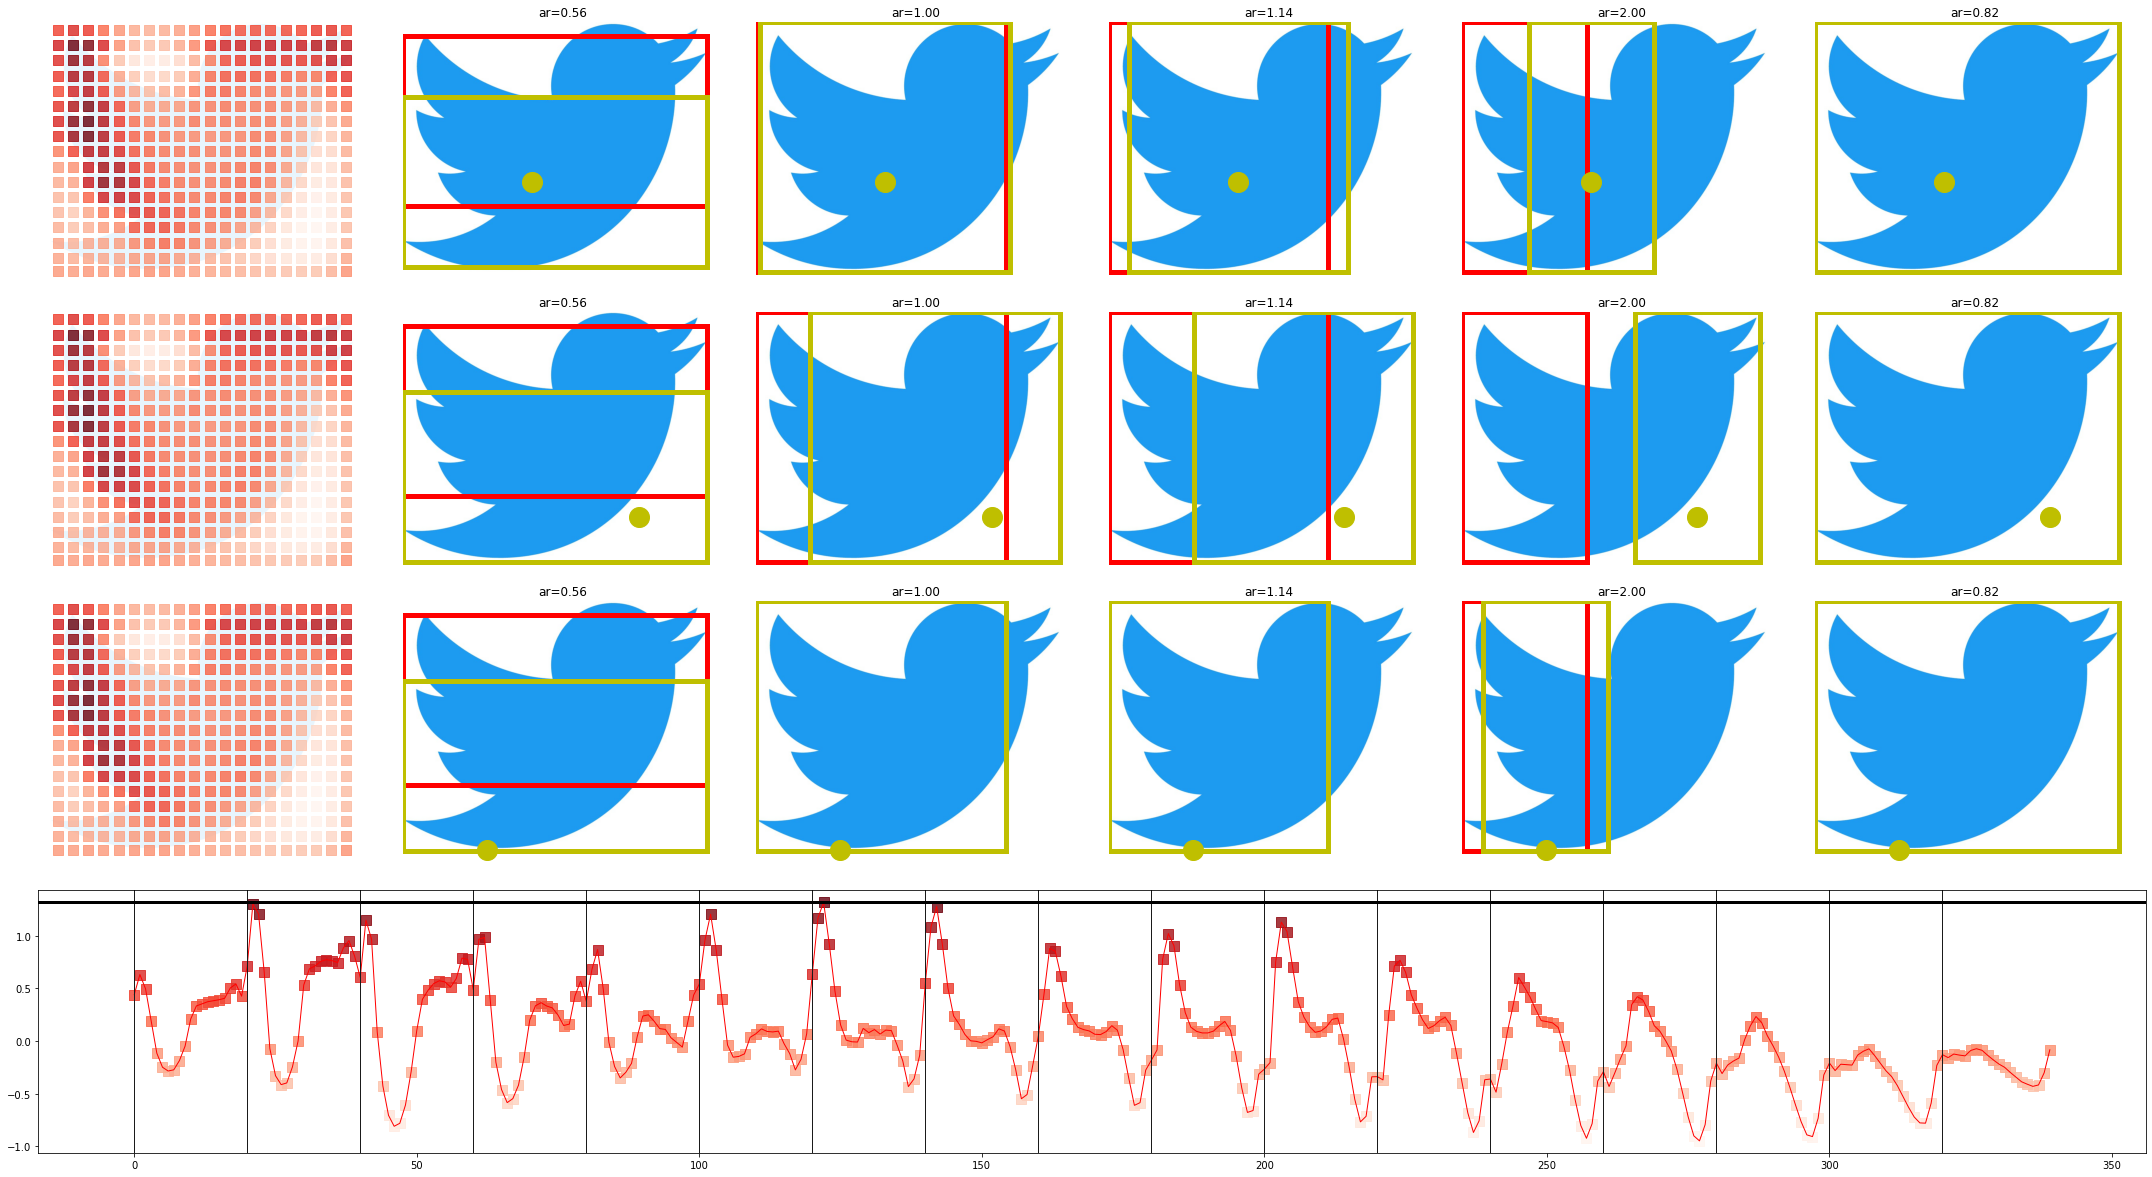

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=3, sample=True)

## Crop an image generated using combination of images

In [ ]:
from PIL import Image

from image_manipulation import join_images

In [ ]:
my_num = [str(x) for x in range(1, 51)]
# exclude = [str(x) for x in range(26, 51)]
# my_num = [x for x in my_num if x not in exclude]
my_num

In [ ]:
# images = [Image.open(x) for x in data_dir.glob("./*ern" + num + ".jpg")]
# img = join_images(images, col_wrap=2, img_size=(128, -1))

In [ ]:
# img

In [ ]:
from tqdm import tqdm
# Initialize my dictionary
my_results_dict = {}
for num in my_num:
    my_results_dict[num] = {'e_s': '', 's_e': ''}

# Eastern Western Horizontal Stitch
for num in tqdm(my_num):
    images = [
        Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
        Image.open(data_dir / Path("./straight" + num + ".jpg")),
    ]
    img, x_sep, y_sep = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
    x, y = model.plot_img_crops_using_img(img, topK=1)
    if x > x_sep:
        my_results_dict[num]['e_s'] = 's'
    else:
        my_results_dict[num]['e_s'] = 'e'

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Western Eastern Horizontal Stitch
for num in tqdm(my_num):
    images = [
        Image.open(data_dir / Path("./straight" + num + ".jpg")),
        Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
    ]
    img, x_sep, y_sep = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
    x, y = model.plot_img_crops_using_img(img, topK=1)
    if x > x_sep:
        my_results_dict[num]['s_e'] = 'e'
    else:
        my_results_dict[num]['s_e'] = 's'

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Find stats here, for horizontal stitching
count_clearly_straight = 0
count_clearly_ethnic = 0
count_confused = 0
for num in my_num:
    if my_results_dict[num]['s_e'] == 's' and my_results_dict[num]['e_s'] == 's':
        count_clearly_straight += 1
    elif my_results_dict[num]['s_e'] == 'e' and my_results_dict[num]['e_s'] == 'e':
        count_clearly_ethnic += 1
    else:
        count_confused += 1
print("horizontal stitching:")
print("ethnic", count_clearly_ethnic)
print("straight", count_clearly_straight)
print("confused", count_confused)

In [ ]:
times_ethnic_was_preferred = 0
times_straight_was_preferred = 0
for num in my_num:
    if my_results_dict[num]['s_e'] == 's':
        times_straight_was_preferred += 1
    if  my_results_dict[num]['e_s'] == 's':
        times_straight_was_preferred += 1
    if my_results_dict[num]['s_e'] == 'e':
        times_ethnic_was_preferred += 1
    if my_results_dict[num]['e_s'] == 'e':
        times_ethnic_was_preferred += 1
print(times_ethnic_was_preferred)
print(times_straight_was_preferred)
import numpy
from statsmodels.stats.proportion import proportions_ztest
count = np.array([18+3, 28+3])
nobs = np.array([50, 50])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

In [ ]:
# Initialize my dictionary
my_results_dict = {}
for num in my_num:
    my_results_dict[num] = {'e_s': '', 's_e': ''}

# Eastern Western Vertical Stitch
for num in tqdm(my_num):
    images = [
        Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
        Image.open(data_dir / Path("./straight" + num + ".jpg")),
    ]
    img, x_sep, y_sep = join_images(images, col_wrap=1, img_size=(128, 128), padding=100)
    x, y = model.plot_img_crops_using_img(img, topK=1)
    if y > y_sep:
        my_results_dict[num]['e_s'] = 's'
    else:
        my_results_dict[num]['e_s'] = 'e'

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Western Eastern Vertical Stitch
for num in tqdm(my_num):
    images = [
        Image.open(data_dir / Path("./straight" + num + ".jpg")),
        Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
    ]
    img, x_sep, y_sep = join_images(images, col_wrap=1, img_size=(128, 128), padding=100)
    x, y = model.plot_img_crops_using_img(img, topK=1)
    if y > y_sep:
        my_results_dict[num]['s_e'] = 'e'
    else:
        my_results_dict[num]['s_e'] = 's'

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Find stats here, for vertical stitching
count_clearly_straight = 0
count_clearly_ethnic = 0
count_confused = 0
for num in my_num:
    if my_results_dict[num]['s_e'] == 's' and my_results_dict[num]['e_s'] == 's':
        count_clearly_straight += 1
    elif my_results_dict[num]['s_e'] == 'e' and my_results_dict[num]['e_s'] == 'e':
        count_clearly_ethnic += 1
    else:
        count_confused += 1
print("vertical stitching:")
print("ethnic", count_clearly_ethnic)
print("straight", count_clearly_straight)
print("confused", count_confused)

In [ ]:
"""
times_eastern_was_preferred = 0
times_western_was_preferred = 0
for num in my_num:
    if my_results_dict[num]['western_eastern'] == 'western':
        times_western_was_preferred += 1
    if  my_results_dict[num]['eastern_western'] == 'western':
        times_western_was_preferred += 1
    if my_results_dict[num]['western_eastern'] == 'eastern':
        times_eastern_was_preferred += 1
    if my_results_dict[num]['eastern_western'] == 'eastern':
        times_eastern_was_preferred += 1
print(times_eastern_was_preferred)
print(times_western_was_preferred)
"""
import numpy
from statsmodels.stats.proportion import proportions_ztest
count = np.array([13+3, 34+3])
nobs = np.array([50, 50])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.6f}'.format(pval))

In [ ]:
# unmatched experiments
from tqdm import tqdm

In [ ]:
# Initialize my dictionary
my_results_dict = {}
for num_east in my_num:
    for num_west in my_num:
        my_results_dict[num_east, num_west] = {'e_s': '', 's_e': ''}

# Eastern Western Horizontal Stitch
for num_east in tqdm(my_num):
    for num_west in my_num:
        images = [
            Image.open(data_dir / Path("./ethnic" + num_east + ".jpg")),
            Image.open(data_dir / Path("./straight" + num_west + ".jpg")),
        ]
        img, x_sep, y_sep = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
        x, y = model.plot_img_crops_using_img(img, topK=1)
        if x > x_sep:
            my_results_dict[num_east, num_west]['e_s'] = 's'
        else:
            my_results_dict[num_east, num_west]['e_s'] = 'e'

In [ ]:
# Western Eastern Horizontal Stitch
# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21
# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20
for num_east in tqdm(my_num):
    for num_west in my_num:
        images = [
            Image.open(data_dir / Path("./straight" + num_west + ".jpg")),
            Image.open(data_dir / Path("./ethnic" + num_east + ".jpg")),
        ]
        img, x_sep, y_sep = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
        x, y = model.plot_img_crops_using_img(img, topK=1)
        if x > x_sep:
            my_results_dict[num_east, num_west]['s_e'] = 'e'
        else:
            my_results_dict[num_east, num_west]['s_e'] = 's'

In [ ]:
# Find stats here, for horizontal stitching
count_clearly_straight = 0
count_clearly_ethnic = 0
count_confused = 0
for num_east in tqdm(my_num):
    for num_west in my_num:
        if my_results_dict[num_east, num_west]['s_e'] == 's' and my_results_dict[num_east, num_west]['e_s'] == 's':
            count_clearly_straight += 1
        elif my_results_dict[num_east, num_west]['s_e'] == 'e' and my_results_dict[num_east, num_west]['e_s'] == 'e':
            count_clearly_ethnic += 1
        else:
            count_confused += 1
print("horizontal stitching:")
print("ethnic", count_clearly_ethnic)
print("straight", count_clearly_straight)
print("confused", count_confused)

In [ ]:
# times_eastern_was_preferred = 0
# times_western_was_preferred = 0
# for num_east in my_num:
#     for num_west in my_num:
#         if my_results_dict[num_east, num_west]['western_eastern'] == 'western':
#             times_western_was_preferred += 1
#         if  my_results_dict[num_east, num_west]['eastern_western'] == 'western':
#             times_western_was_preferred += 1
#         if my_results_dict[num_east, num_west]['western_eastern'] == 'eastern':
#             times_eastern_was_preferred += 1
#         if my_results_dict[num_east, num_west]['eastern_western'] == 'eastern':
#             times_eastern_was_preferred += 1
# print(times_eastern_was_preferred)
# print(times_western_was_preferred)
import numpy
from statsmodels.stats.proportion import proportions_ztest
count = np.array([2404, 2596])
nobs = np.array([5000, 5000])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

In [ ]:
# Initialize my dictionary
my_results_dict = {}
for num_east in my_num:
    for num_west in my_num:
        my_results_dict[num_east, num_west] = {'e_s': '', 's_e': ''}

# Eastern Western Vertical Stitch
for num_east in tqdm(my_num):
    for num_west in my_num:
        images = [
            Image.open(data_dir / Path("./ethnic" + num_east + ".jpg")),
            Image.open(data_dir / Path("./straight" + num_west + ".jpg")),
        ]
        img, x_sep, y_sep = join_images(images, col_wrap=1, img_size=(128, 128), padding=100)
        x, y = model.plot_img_crops_using_img(img, topK=1)
        if y > y_sep:
            my_results_dict[num_east, num_west]['e_s'] = 's'
        else:
            my_results_dict[num_east, num_west]['e_s'] = 'e'

In [ ]:
# Western Eastern Vertical Stitch
for num_east in tqdm(my_num):
    for num_west in my_num:
        images = [
            Image.open(data_dir / Path("./straight" + num_west + ".jpg")),
            Image.open(data_dir / Path("./ethnic" + num_east + ".jpg")),
        ]
        img, x_sep, y_sep = join_images(images, col_wrap=1, img_size=(128, 128), padding=100)
        x, y = model.plot_img_crops_using_img(img, topK=1)
        if y > y_sep:
            my_results_dict[num_east, num_west]['s_e'] = 'e'
        else:
            my_results_dict[num_east, num_west]['s_e'] = 's'

In [ ]:
# Find stats here, for Vertical stitching
count_clearly_straight = 0
count_clearly_ethnic = 0
count_confused = 0
for num_east in tqdm(my_num):
    for num_west in my_num:
        if my_results_dict[num_east, num_west]['s_e'] == 's' and my_results_dict[num_east, num_west]['e_s'] == 's':
            count_clearly_straight += 1
        elif my_results_dict[num_east, num_west]['s_e'] == 'e' and my_results_dict[num_east, num_west]['e_s'] == 'e':
            count_clearly_ethnic += 1
        else:
            count_confused += 1
print("vertical stitching:")
print("ethnic", count_clearly_ethnic)
print("straight", count_clearly_straight)
print("confused", count_confused)

In [ ]:
# times_eastern_was_preferred = 0
# times_western_was_preferred = 0
# for num_east in my_num:
#     for num_west in my_num:
#         if my_results_dict[num_east, num_west]['western_eastern'] == 'western':
#             times_western_was_preferred += 1
#         if  my_results_dict[num_east, num_west]['eastern_western'] == 'western':
#             times_western_was_preferred += 1
#         if my_results_dict[num_east, num_west]['western_eastern'] == 'eastern':
#             times_eastern_was_preferred += 1
#         if my_results_dict[num_east, num_west]['eastern_western'] == 'eastern':
#             times_eastern_was_preferred += 1
# print(times_eastern_was_preferred)
# print(times_western_was_preferred)
import numpy
from statsmodels.stats.proportion import proportions_ztest
count = np.array([2955, 2045])
nobs = np.array([5000, 5000])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

In [ ]:
num = '12'
images = [
    Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
    Image.open(data_dir / Path("./straight" + num + ".jpg")),
]
img, x_sep, y_sep = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
x, y = model.plot_img_crops_using_img(img, topK=1)
print(x, y)
print(x_sep)
print(y_sep)
# print(model.plot_img_crops_using_img(img, topK=1))
# print(salient_x, salient_y)
plt.savefig("ethnic" + num + "_straight" + num + ".jpeg", bbox_inches="tight")

In [ ]:

images = [
    Image.open(data_dir / Path("./straight" + num + ".jpg")),
    Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
]
img, x_sep, y_sep = join_images(images, col_wrap=2, img_size=(128, 128), padding=0)
model.plot_img_crops_using_img(img, topK=1)
plt.savefig("straight" + num + "_ethnic" + num + ".jpeg", bbox_inches="tight")

In [ ]:
num = '12'
images = [
    Image.open(data_dir / Path("./straight" + num + ".jpg")),
    Image.open(data_dir / Path("./ethnic" + num + ".jpg")),
]
img, x_sep, y_sep = join_images(images, col_wrap=1, img_size=(128, 128), padding=100)
print("this is the separation line")
print(x_sep, y_sep)
x, y = model.plot_img_crops_using_img(img, topK=1)
print("these are the saliency coordinates")
print(x, y)

In [ ]:
img

In [ ]:
img.save("ethnic" + num + "_straight" + num + "_stiched.jpeg", "JPEG")

In [ ]:
img_path = Path("ethnic" + num + "_straight" + num + "_stiched.jpeg")
model.plot_img_crops(img_path, topK=1)
plt.savefig("ethnic" + num + "_straight" + num + ".jpeg", bbox_inches="tight")

In [ ]:
model.plot_img_crops(data_dir / Path("./dummy.jpeg"), topK=2, aspectRatios=[0.56])
plt.savefig("dummy.jpeg", bbox_inches="tight")

In [ ]:
img_path = Path("ethnic1_straight1stiched.jpeg")
model.plot_img_crops(img_path, topK=1, add_saliency_line=False, col_wrap=3)
plt.savefig("ethnic1_straight1.jpeg", bbox_inches="tight")